In [15]:
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.io
import itertools as it
import scipy.special as psi
plt.style.use('classic')
import seaborn as sns
import pandas as pd
import math as mt
import time
import sys

sys.path.insert(1, '/rds/general/user/lr4617/home/4th_Year_Project/Final_Year_Project/')

from scipy.io import loadmat
from scipy import stats
from numpy.random import seed
from numpy.random import rand
from scipy.integrate import quad
from scipy.io import savemat
from tempfile import TemporaryFile
from scipy.io import loadmat
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.decomposition import KernelPCA
from mpl_toolkits import mplot3d
from mPE_fn import mPE_
from scipy.spatial import distance
from scipy.stats import entropy
from mPE_ultis import integrand, ubble, array_list, permutation
from util import rolling_mean, probability, get_mPE_matrix, get_vel_matrix
from sklearn.cluster import KMeans

###################################################################################################################################################
################################################################ LOAD TRAJECTORIES ################################################################
###################################################################################################################################################

print('########################## LOADING TRAJECTORIES ##########################')

sub_sampling = 50
modes = ['drug']
root_dir = '/rds/general/user/lr4617/home/4th_Year_Project/CAPTURE_rat_multidimensional/raw_data/'
# load entire high-dimensional trajectories
cnt = 0
lengths = []
for mode in modes:
    trajs = os.listdir(root_dir + mode + '/' )
    for traj_n in trajs:
        if traj_n != '.ipynb_checkpoints': 
            # loading entire high-dimensional trajectory
            path = root_dir + mode + '/' + traj_n + '/' + 'trajectories_na/'
            trajectories = os.listdir(path)
            # removing NaN columns
            nan_cols = []
            for i, time_bin in enumerate(trajectories):
                if time_bin != 'behavs' and time_bin != '.ipynb_checkpoints':
                    trajectory = loadmat(path + time_bin)
                    trajectory = trajectory['trajectory'] 
                    for i in range(trajectory.shape[1]):
                        if np.isnan(trajectory[:, i]).all():
                            nan_cols.append(i)

            # create entire trajectory
            nan_cols = np.asarray(nan_cols)
            if nan_cols.size > 0:
                if len(np.where(nan_cols==nan_cols[0])[0])*3 == len(nan_cols):
                    all_trajectories =  np.zeros( (int((trajectory.shape[0]*len(trajectories))), trajectory.shape[1]-len(nan_cols)) )
                    sampled_trajectories =  np.zeros( (int((trajectory.shape[0]*len(trajectories))/sub_sampling), trajectory.shape[1]-len(nan_cols)) )
            else:
                all_trajectories =  np.zeros( (int((trajectory.shape[0]*len(trajectories))), trajectory.shape[1]-len(nan_cols)) )
                sampled_trajectories = np.zeros( (int((trajectory.shape[0]*len(trajectories))/sub_sampling), trajectory.shape[1]) )

            window = sub_sampling
            for i, time_bin in enumerate(trajectories):
                if time_bin != 'behavs' and time_bin != '.ipynb_checkpoints':
                    trajectory = loadmat(path + time_bin)
                    trajectory = trajectory['trajectory'] 
                    idx = np.round(np.arange(0, trajectory.shape[0], sub_sampling)).astype(int)
                    trajectory = trajectory[idx]
                    idx_2 = i*trajectory.shape[0]
                    sampled_trajectories[idx_2:idx_2+trajectory.shape[0], 0:trajectory.shape[1]] = trajectory
                    
            
            # convert nan to number when not it is a sparse recurrence (not an entire COLUMN)
            sampled_trajectories = np.nan_to_num(sampled_trajectories)
            lengths.append(sampled_trajectories.shape[0])
                        
            # append trajectory to all trajectories
            if cnt==0:
                rats = sampled_trajectories
            if cnt>0:
                rats = np.concatenate((rats, sampled_trajectories), axis=0)
                
            cnt += 1

print(rats.shape)


########################## LOADING TRAJECTORIES ##########################
(507600, 60)


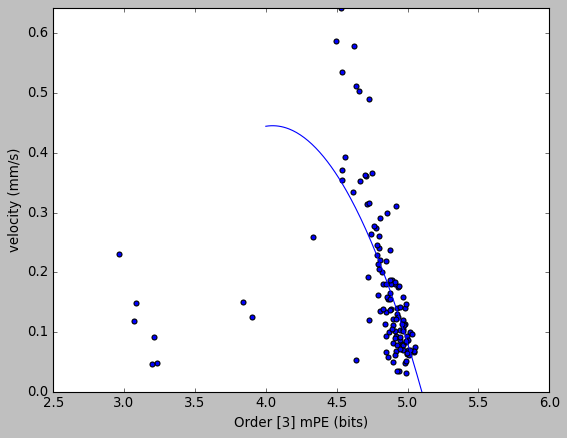

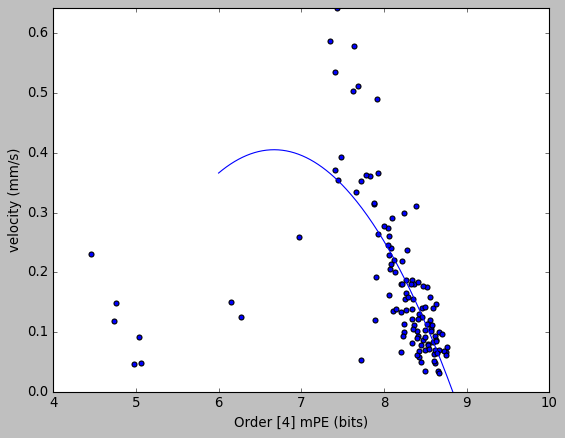

In [17]:
###################################################################################################################################################
############################################################ Velocity vs Entropy ##################################################################
###################################################################################################################################################

# Calculate instantaneous velocity of each datapoint (maybe only consider x-y dims)
fs = 300
minutes = 5
bin_length = fs*60*minutes
unit_length = 1500
traj_number = int(bin_length/unit_length)
bins_number = int(traj.shape[0]/bin_length)
orders = [3, 4]

for order in orders:
    order =  [order]
    mPE_vector, vel_matrix = get_vel_matrix(rats, bins_number, traj_number, order)

    # plotting bin-velocity against corresponding mPE
    vel_vector = vel_matrix.flatten()
    mPE_vector_ = mPE_vector.flatten()
    p = np.polyfit(mPE_vector_, 1000* vel_vector, 2)
    if order[0] == 3:
        x_new = np.linspace(4,5.8,200)
    else:
        x_new = np.linspace(6,9.2,200)

    ffit = np.polyval(p, x_new)

    fig = plt.figure()
    plt.scatter(mPE_vector_, 1000*vel_vector)
    plt.xlabel('Order ' + str(order) + ' mPE (bits)')
    plt.ylabel('velocity (mm/s)')
    plt.ylim([0, 1000*np.max(vel_vector)])
    plt.plot(x_new, ffit)

    path_out = '/rds/general/user/lr4617/home/4th_Year_Project/Final_Report/entropy_analysis/mPE_vs_velocity/' + mode + '_order_' + str(order[0]) + '_traj_' + str(traj_n) + 'png'
    plt.savefig(path_out)
    plt.show()